In [148]:
# Nate Ramos (he/him)
# 01/25/2022
# CEE 266F: PSET 2

In [81]:
from math import gamma as GammaFN
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.optimize import brentq as root
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt

In [9]:
# load data of daily flows on the Assabet River in Maynard, MA
allQ = pd.read_csv('Documents/266F/Assabet_MaynardMA.csv')

# convert first column to date
allQ['Date'] = pd.to_datetime(allQ['Date'])
allQ['Flow'] = pd.to_numeric(allQ['Flow'], errors='ignore')

# find year of each data point
allQ['Year'] = allQ['Date'].dt.year

In [10]:
# Functions used in PSET: Peaks over threshold

# find all peaks over the threshold
x0 = 1200 # peak threshold
peak_indices = np.where(allQ['Flow'] > x0)[0]

# function to calculate moments
def findMoments(data):

    xbar = np.mean(data)
    std = np.std(data, ddof=1) ## sample var
    skew = ss.skew(data,bias=False)

    return xbar, std, skew

# find only independent peaks
# if more than 1 peak over the threshold within 5 days of each other, pick only the largest
def findClusters(indices):
    allClusters = []
    subCluster = [indices[0]]
    for i in range(1,len(indices)):
        if indices[i] - subCluster[-1] <= 5:
            subCluster.append(indices[i])
        else:
            allClusters.append(subCluster)
            subCluster = [indices[i]]

    allClusters.append(subCluster)

    return allClusters

# Updated find peaks function to get dates of peaks
def findPeaks(clusters, data, dataTime):
    peaks = np.zeros(len(clusters))
    dates = []

    for i in range(len(peaks)):
        peaks[i] = np.max(data[clusters[i]])
        ind = np.where(peaks[i] == data[clusters[i]])[0][0]
        dates.append(dataTime[clusters[i][ind]])
    return peaks, dates

In [11]:
# Functions for distribution fit in PSET:
# Fit a gumbel distribution
def fitGumbel(data, method):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        loc, scale = ss.gumbel_r.fit(data)
    elif method == 'MOM':
        scale = math.sqrt(6*std**2/math.pi**2)
        loc = xbar - .5772*scale

    return scale, loc

# Fit a Generalized Pareto distribution
def fitGPD(data, x0, method, initialize=False):
    assert method == 'MLE' or method == 'MOM', "method must = 'MLE' or 'MOM'"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        if initialize == True:
            kappa = 0.5 * (((xbar - x0) / std) ** 2 - 1)
            kappa, x0, alpha = ss.genpareto.fit(data, kappa, floc=x0)
        else:
            kappa, x0, alpha = ss.genpareto.fit(data, floc=x0)
    elif method == 'MOM':
        kappa = 0.5 * (((xbar - x0) / std) ** 2 - 1)
        alpha = (1 + kappa) * (xbar - x0)

    return kappa, x0, alpha

In [12]:
# Functions for Drought Frequency Analysis

# Fit a Weibull distribution. Note if you want the two-parameter Weibull, you have to set npars=2
def fitWeibull(data, method, npars):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        if npars == 2:
            kappa, xi, alpha = ss.weibull_min.fit(data,floc=0)
        elif npars == 3:
            kappa, xi, alpha = ss.weibull_min.fit(data)
    elif method == 'MOM':
        if npars == 2:
            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
        elif npars == 3:
            def equations(p):
                kappa, xi, alpha = p
                mu = alpha*GammaFN(1+1/kappa) + xi
                sigma = np.sqrt(alpha**2*(GammaFN(1+2/kappa)-(GammaFN(1+1/kappa))**2))
                gamma = (GammaFN(1+3/kappa)*alpha**3 -3*mu*sigma**2 - mu**3)/(sigma**3)
                return (mu-xbar, sigma-std, gamma-skew)

            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
            kappa, xi,alpha = fsolve(equations,(kappa,xi,alpha))

    return kappa, xi, alpha

In [99]:
# 1
# P(x >= 1) = 1 - P (x=0)
# P(x>=2) = 1 - P (x=0) - P (x=1)

p_1 = 1/100
n_1 = 10
k_0 = 0
k_1 = 1

# 1 - P(x=0)
p_atleast_1 = 1 - ss.binom.pmf(k_0,n_1,p_1)

# 1 - P(x=0) - P(x=1)
p_atleast_2 = 1 - ss.binom.pmf(k_0,n_1,p_1) - ss.binom.pmf(k_1,n_1,p_1)

print('Probability that 100-yr flood occurs at least once in 10-yr period:', round(p_atleast_1,4))
print('Probability that 100-yr flood occurs at least twice in 10-yr period:', round(p_atleast_2,5))
print('Independence makes sense because of the lengths of time between flood events.') 
print('Unlike precipitation, which occurs daily and can influence the next day, flood events occur less often')

Probability that 100-yr flood occurs at least once in 10-yr period: 0.0956
Probability that 100-yr flood occurs at least twice in 10-yr period: 0.00427
Independence makes sense because of the lengths of time between flood events.
Unlike precipitation, which occurs daily and can influence the next day, flood events occur less often


In [19]:
#2a - Find the annual maxima in each year
maxQYear = allQ.groupby('Year').max()

# Get just the flow vector for annual maxima as numpy array
maxQ = np.array(maxQYear['Flow'])

print('Vector of Annual Maxima:',maxQ)

# Get just the year vector for annual maxima as numpy array
yearMaxQ = np.array(maxQYear['Date'].dt.year)

Vector of Annual Maxima: [ 157.  900.  825.  616.  908. 1060.  638. 1420.  468.  740. 1000.  763.
 1100. 1970. 3650. 1330.  656. 1270. 1170. 1210.  994. 1580. 1720.  799.
  500.  380.  965. 3170. 1630. 1640.  833. 1500. 1140.  806.  996.  954.
 1220. 1330. 3240.  929.  838. 2230. 1230. 1730.  562. 1330. 2490.  657.
  729.  737.  751.  496. 1900. 1360.  713. 1550. 1140. 1500.  770. 1480.
 2020.  859.  999. 1590. 1560. 1390. 1970. 1440.  794. 2400. 1340.  633.
 1190. 1470.  896.  592. 1210. 1170. 1010.  978. 1230.]


In [42]:
# 2b

#Gumbel parameter estimates 
scale_MOM, loc_MOM = fitGumbel(maxQ, 'MOM')

scale_MLE, loc_MLE = fitGumbel(maxQ,'MLE')

# Gumbel x_p
p_100 = 1 - 1/100 # return period for 100-yr flood, 1-1/T
x_99th = ss.gumbel_r.ppf(p_100,loc_MLE,scale_MLE)

p_500 = 1 - 1/500 # return period for 500-yr flood
x_99and8th = ss.gumbel_r.ppf(p_500,loc_MLE,scale_MLE)

print('Gumbel MOM parameter estimates:',round(scale_MOM), ',', round(loc_MOM))
print('Gumbel MLE parameter estimates:',round(scale_MLE), ',', round(loc_MLE))
print('100-year flood estimate (99th percentile):', round(x_99th),'cfs')
print('500-year flood estimate (99.8th percentile):', round(x_99and8th),'cfs')

Gumbel MOM parameter estimates: 489 , 942
Gumbel MLE parameter estimates: 444 , 958
100-year flood estimate (99th percentile): 3000 cfs
500-year flood estimate (99.8th percentile): 3717 cfs


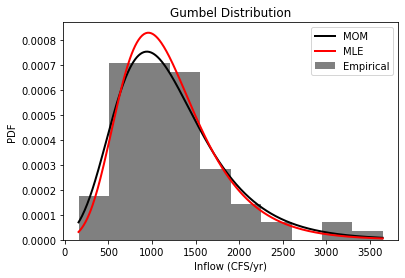

In [61]:
# Gumbel plots
plt.figure()
plt.hist(maxQ, density=True, color='gray', edgecolor='none',label='Empirical')
# plt.plot(np.sort(maxQ), np.linspace(0, 1, len(maxQ), endpoint=False), label='eCDF')
x = np.arange(min(maxQ),max(maxQ), 10) # points to plot at
pdf_gumb_MOM = ss.gumbel_r.pdf(x,loc_MOM,scale_MOM)
pdf_gumb_MLE = ss.gumbel_r.pdf(x,loc_MLE,scale_MLE)

plt.plot(x, pdf_gumb_MOM, color='k', linewidth=2,label='MOM')
plt.plot(x,pdf_gumb_MLE,color='r',linewidth=2,label='MLE')
plt.legend()
plt.xlabel('Inflow (CFS/yr)')
plt.ylabel('PDF')
plt.title('Gumbel Distribution')
plt.show()

print('Visually, the MLE seems to best capture the empirical tails, while the MOM captures the peak shoulders slightly better.')

In [102]:
# 2c
# Gumbel 100-yr flood CI
n_g = len(maxQ)
y_g_100 = -np.log(-np.log(1-1/100))

var_x_100 = (np.square(scale_MLE)*(1.11+.52*y_g_100+.61*np.square(y_g_100)))/n_g
z = 1.96

ci_x_100_up = (x_100 - z * var_x_100 ** .5)
ci_x_100_down = (x_100 + z * var_x_100 ** .5)

# Gumbel 500-yr CI
y_g_500 = -np.log(-np.log(1-1/500))

var_x_500 = (np.square(scale_MLE)*(1.11+.52*y_g_500+.61*np.square(y_g_500)))/n_g

ci_x_500_up = (x_500-(z)*(var_x_500)**.5)
ci_x_500_down = (x_500+(z)*(var_x_500)**.5)

print('100-yr flood estimates 95% CI:',round(ci_x_100_up),'cfs,',round(ci_x_100_down), 'cfs')
print('500-yr flood estimates 95% CI:',round(ci_x_500_up),'cfs,',round(ci_x_500_down), 'cfs')
print('The 500-year flood has a lower probability of occurring than the 100-year flood even, and thus has a higher Variance value.')
print('Thus, this higher Variance value is added/subtracted to x_p, leading to a wider CI for the 500-year flood than the 100-year flood.')

100-yr flood estimates 95% CI: 2609 cfs, 3392 cfs
500-yr flood estimates 95% CI: 3206 cfs, 4227 cfs
The 500-year flood has a lower probability of occurring than the 100-year flood even, and thus has a higher Variance value.
Thus, this higher Variance value is added/subtracted to x_p, leading to a wider CI for the 500-year flood than the 100-year flood.


In [33]:
# 2d, Threshold of x0 = 1200 cfs
clusters = findClusters(peak_indices)
peaks, dates = findPeaks(clusters, allQ['Flow'], allQ['Date'])

print("Peaks over threshold of 1200 cfs, with peaks within 5 days removed:", peaks)

Peaks over threshold of 1200 cfs, with peaks within 5 days removed: [1420. 1970. 3650. 1210. 1330. 1210. 1270. 1220. 1210. 1580. 1720. 3170.
 1630. 1450. 1640. 1500. 1500. 1220. 1210. 1330. 3240. 2230. 1230. 1290.
 1730. 1330. 2490. 1900. 1360. 1550. 1490. 1480. 1500. 1450. 1480. 2020.
 1590. 1560. 1470. 1250. 1390. 1970. 1440. 1380. 1760. 2400. 1340. 1470.
 1210. 1230.]


In [103]:
# 2e

lambda_n = len(maxQ) # 81 years on record
lambda_arrivals = len(peaks) # 50 floods over threshold, w/in 5 day clusters removed
lambda_MLE = lambda_arrivals / lambda_n

print('Poisson arrival rate of floods over threshold:', round(lambda_MLE,3), 'floods/year.')
print('This suggests that floods occur every ~', 1/lambda_MLE,' years. So, roughly every 1-2 years, one may expect a flood over the threshold to occur.')

Poisson arrival rate of floods over threshold: 0.617 floods/year.
This suggests that floods occur every ~ 1.62  years. So, roughly every 1-2 years, one may expect a flood over the threshold to occur.


In [107]:
# %%
# 2f
# GPD parameter estimates
kappa_MLE, x0, alpha_MLE = fitGPD(peaks, x0, 'MLE')
# .244, 1200, 332
kappa_MOM, x0, alpha_MOM = fitGPD(peaks, x0, 'MOM')
#-.172, 1200, 359

print('GPD MLE parameter estimates:', round(kappa_MLE,3), ',', round(alpha_MLE))
print('GPD MOM parameter estimates:', round(kappa_MOM,3), ',', round(alpha_MOM))

print('While the alpha estimates are closer to each other than the kappa estimates, \nthe subsequent plots below differ minimally between MLE and MOM parameter estimates.')


GPD MLE parameter estimates: 0.244 , 331
GPD MOM parameter estimates: -0.172 , 359
While the alpha estimates are closer to each other than the kappa estimates, 
the subsequent plots below differ minimally between MLE and MOM parameter estimates.


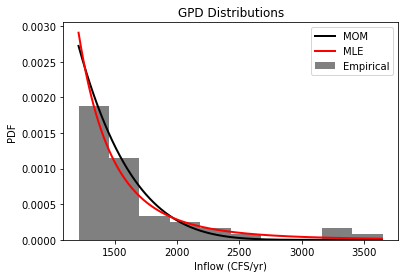

The MLE parameter estimates seem to better capture the tails of the empirical distribution.
This seems to be quite important at and after 2500 cfs/year, as the MMOM curve is nearly 0 while the MLE curve stays near the histogram.
On the other hand, the MOM parameter estimates seem to more accurately capture the middle of the histogram.


In [76]:
# GPD plots
plt.figure()
plt.hist(peaks, density=True, color='gray', edgecolor='none',label='Empirical')
x_GPD = np.arange(min(peaks),max(peaks), 10) # points to plot at
pdf_GPD_MOM = ss.genpareto.pdf(x_GPD, kappa_MOM,  x0, alpha_MOM)
pdf_GPD_MLE = ss.genpareto.pdf(x_GPD,kappa_MLE, x0, alpha_MLE)

plt.plot(x_GPD, pdf_GPD_MOM, color='k', linewidth=2,label='MOM')
plt.plot(x_GPD,pdf_GPD_MLE,color='r',linewidth=2,label='MLE')
plt.legend()
plt.xlabel('Inflow (CFS/yr)')
plt.ylabel('PDF')
plt.title('GPD Distributions')
plt.show()

print('The MLE parameter estimates seem to better capture the tails of the empirical distribution.')
print('This seems to be quite important at and after 2500 cfs/year, as the MOM curve is nearly 0 while the MLE curve stays near the histogram.')
print('On the other hand, the MOM parameter estimates seem to more accurately capture the middle of the histogram.')

In [ ]:
# 3
# a
print('The estimate at gage no. 01097000 for a 100-yr flood is 3954 cfs, and for a 500-yr flood 5444 cfs.')

# b
print('First, they used the expected moments algorithm for an initial analysis of annual peak flows at 153 streamgages throughout New England for determining appropriate skew for weighting at-site skew.')
print('\nFollowing 1981 guidelines from the Interagency Committee on Water, they fit annual peak flows at a streamgage to a log-Pearson type III distribution to compute the magnitude of the flood for a given Annual Exceedance Probability (AEP).')
print('\Additionally, they adjust for low outliers which skew the distribution to the left, while they are interested in magnitudes of floods with AEPs of 50% or less.')

# c
print('\nIn Question 2, we looked at a single streamgage for our data (con, small sample size), while Question 3 used data from 153 streamgages, offering a more robust analysis due to larger sample size (a pro).')
print('\nIn Question 2, we processed the data for the GPD, and Question 3 adjusted for low outliers in the data--both pros.')
print('\nThe online tool in Question 3 was much easier to use than manually calculating AEPs and their related flows.')


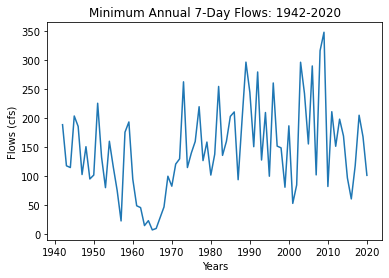

In [108]:
# 4 7Q10
# filtering to remove incomplete years
allQ_filt = allQ[allQ['Date'].dt.year != 1941]
allQ_filt = allQ_filt[allQ_filt['Date'].dt.year != 2021]
# reset the indices after removing first incomplete year of data for index looping purposes
allQ_filt = allQ_filt.reset_index(drop=True) 
# remove the first and last year from years (1941, 2021) for reasons above
yearMaxQ_filt = yearMaxQ[1:-1]
# group flow data into a list per year
allQ_yearly = allQ_filt.groupby('Year')['Flow'].apply(list)

Min7DayFlow = []
SevenDayFlow_calcs = []
Yearly_Daily_Flows =[]
SevenDayFlow = []

# compute annual min 7-day flows
for year in yearMaxQ_filt:
    Yearly_Daily_Flows = allQ_yearly[year]
    for s in range(len(Yearly_Daily_Flows)):
        if s > 5:
            SevenDayFlow_calc = sum(Yearly_Daily_Flows[s-6:s+1])
            SevenDayFlow.append(SevenDayFlow_calc) 
    Min7DayFlow.append(min(SevenDayFlow))
    SevenDayFlow = [] # reset list to ensure min of each year, not of multiple years
# Min 7Q10 Plot
plt.figure()
plt.plot(yearMaxQ_filt,Min7DayFlow)
plt.title('Minimum Annual 7-Day Flows: 1942-2020')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.show()

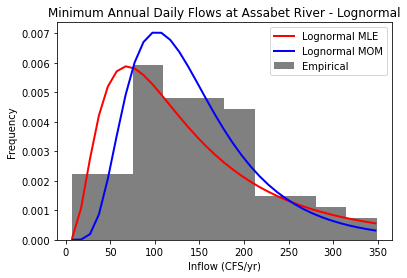

While the MLE curve seems to capture the tails of the histogram better, 
the MOM curve better captures the shoulders of the peak (while perhaps overestimating the peak).


In [86]:
# 4a Lognormal-2 MOM fit - plots
m_ln_MOM = np.mean(Min7DayFlow)
s_ln_MOM = np.std(Min7DayFlow)

# MOM use derived equations from lecture
mu_hat = np.log(m_ln_MOM) - 1/2 * np.log(s_ln_MOM**2 / m_ln_MOM**2 + 1)
sigma_sq_hat = np.log(s_ln_MOM**2 / m_ln_MOM**2 + 1)

# 4b Lognormal-2 MLE fit - plots

# fit a log-normal distribution to the data
shape_ln_MLE, loc_ln_MLE, scale_ln_MLE = ss.lognorm.fit(Min7DayFlow, floc=0)

# All LN fits plotted together with histogram

# location equals 0 for LN-2

plt.figure()
plt.hist(Min7DayFlow, density=True, color='gray', edgecolor='none', label='Empirical')
x_LN = np.arange(min(Min7DayFlow),max(Min7DayFlow), 10) # points to plot at
pdf_log_MOM = ss.lognorm.pdf(x_LN, loc=0, scale=np.exp(mu_hat), s=np.sqrt(sigma_sq_hat))
pdf_log_MLE = ss.lognorm.pdf(x_LN, loc=0, scale=scale_ln_MLE, s=shape_ln_MLE)

plt.plot(x_LN, pdf_log_MOM, color='b', linewidth=2, label='Lognormal MOM')
plt.plot(x_LN, pdf_log_MLE, color='r', linewidth=2, label='Lognormal MLE')
plt.xlabel('Inflow (CFS/yr)')
plt.ylabel('Frequency')
plt.title('Minimum Annual Daily Flows at Assabet River - Lognormal')
plt.legend()
plt.show()

print('While the MLE curve seems to capture the tails of the histogram better, \nthe MOM curve better captures the shoulders of the peak (while perhaps overestimating the peak).')

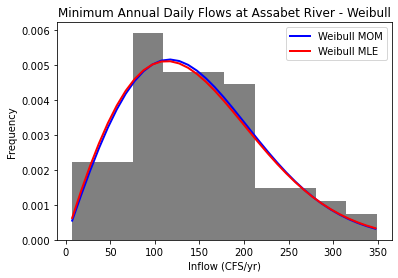

The MOM and MLE curves are nearly identical, with the MLE capturing the tails slightly better, 
while the MOM slightly captures the right shoulder of the peak better.


In [89]:
# %% Weibull-2 MOM fit - plots

# fit a log-normal distribution to the data
shape_W_MLE, xi_W_MLE, scale_W_MLE = fitWeibull(Min7DayFlow, 'MLE', npars = 2)

# %% Weibull MOM fit

# fit a log-normal distribution to the data
shape_W_MOM, xi_W_MOM, scale_W_MOM = fitWeibull(Min7DayFlow, 'MOM', npars = 2)

# All Weibull fits plotted together with histogram

# location equals 0 for Weibull-2

plt.figure()
plt.hist(Min7DayFlow, density=True, color='gray', edgecolor='none')
x_W = np.arange(min(Min7DayFlow),max(Min7DayFlow), 10) # points to plot at
pdf_W_MOM = ss.weibull_min.pdf(x_W,shape_W_MOM,0,scale_W_MOM)
pdf_W_MLE = ss.weibull_min.pdf(x_W,shape_W_MLE,0,scale_W_MLE)

plt.plot(x_W, pdf_W_MOM, color='b', linewidth=2, label='Weibull MOM')
plt.plot(x_W, pdf_W_MLE, color='r', linewidth=2, label='Weibull MLE')
plt.xlabel('Inflow (CFS/yr)')
plt.ylabel('Frequency')
plt.title('Minimum Annual Daily Flows at Assabet River - Weibull')
plt.legend()
plt.show()

print('The MOM and MLE curves are nearly identical, with the MLE capturing the tails slightly better, \nwhile the MOM slightly captures the right shoulder of the peak better.')

In [125]:
# 4 - Parameter and 7Q10 estimates for distribution type


LN_MOM_7Q10 = ss.lognorm.ppf(1/10,np.sqrt(sigma_sq_hat),0, np.exp(mu_hat))
print('LN-2 Shape MOM:',round(np.sqrt(sigma_sq_hat),3), 'LN Scale MOM:', round(np.exp(mu_hat)))
print('LN-2 MOM 7Q10:', round(LN_MOM_7Q10,1))

LN_MLE_7Q10 = ss.lognorm.ppf(1/10,shape_ln_MLE,0,scale_ln_MLE)
print('\nLN-2 Shape MLE:', round(shape_ln_MLE,3), 'LN Scale MLE:', round(scale_ln_MLE))
print('LN-2 MLE 7Q10:', round(LN_MLE_7Q10,1))


W_MOM_7Q10 = ss.weibull_min.ppf(1/10,shape_W_MOM,0,scale_W_MOM)
print('\nWeibull-2 Shape MOM:', round(shape_W_MOM,2),'Weibull Scale MOM:', round(scale_W_MOM))
print('Weibull-2 MOM 7Q10:', round(W_MOM_7Q10,1))


W_MLE_7Q10 = ss.weibull_min.ppf(1/10,shape_W_MLE,0,scale_W_MLE)
print('\nWeibull-2 Shape MLE:', round(shape_W_MLE,2),'Weibull Scale MLE:', round(scale_W_MLE))
print('Weibull-2 MLE 7Q10:', round(W_MLE_7Q10,1))

LN Shape MOM: 0.491 LN Scale MOM: 130
LN MOM 7Q10: 69.2

LN Shape MLE: 0.747 LN Scale MLE: 120
LN MLE 7Q10: 46.0

Weibull Shape MOM: 1.99 Weibull Scale MOM: 165
Weibull MOM 7Q10: 53.3

Weibull Shape MLE: 1.94 Weibull Scale MLE: 164
Weibull MLE 7Q10: 51.6


In [147]:
# K-S test
print('LN-2 MOM:', ss.kstest(Min7DayFlow, 'lognorm', args = [np.sqrt(sigma_sq_hat),0,np.exp(mu_hat)]))
print('With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Lognormal-2 distribution (via MOM).')

print('\nLN-2 MLE:', ss.kstest(Min7DayFlow,'lognorm', args = [shape_ln_MLE, 0, scale_ln_MLE]))
print('With a high D value and a p-value < .05, I can reject the null hypothesis that the Min7DayFlow data comes from a Lognormal-2 distribution (via MLE).')

print('\nWeibull-2 MOM:', ss.kstest(Min7DayFlow,'weibull_min', args =[shape_W_MOM,0,scale_W_MOM]))
print('With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Weibull-2 distribution (via MOM).')

print('\nWeibull-2 MLE:', ss.kstest(Min7DayFlow,'weibull_min', args = [shape_W_MLE,0,scale_W_MLE]))
print('With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Weibull-2 distribution (via MLE).')

print('\nBased on K-S test results, it seems dubious as to whether the Min7DayFlow data comes from a Lognormal-2 distribution since H_0 was rejected \nfor the MLE method and not the MOM method.')
print('The K-S test results suggest that we cannot say assume that the Min7DayFlow data does not come from a Weibull-2 distribution (via MOM or MLE). \nFurther tests can be done to assess the goodness-of-fit fo the Weibull distribution to this data, such as QQ plots')

LN-2 MOM: KstestResult(statistic=0.09235432812888558, pvalue=0.4822896234999535)
With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Lognormal-2 distribution (via MOM).

LN-2 MLE: KstestResult(statistic=0.15682753991672918, pvalue=0.03657115151077353)
With a high D value and a p-value < .05, I can reject the null hypothesis that the Min7DayFlow data comes from a Lognormal-2 distribution (via MLE).

Weibull-2 MOM: KstestResult(statistic=0.06251626986316575, pvalue=0.8978657132196964)
With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Weibull-2 distribution (via MOM).

Weibull-2 MLE: KstestResult(statistic=0.07137729268500234, pvalue=0.7889069763562157)
With a low D value and a p-value > .05, I cannot reject the null hypothesis that the Min7DayFlow data comes from a Weibull-2 distribution (via MLE).

Based on K-S test results, it seems dubious as to whether the M